In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTENC

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 10)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics =['accuracy', recall_m, precision_m, f1_m] 

In [ ]:
#Funzione per plot metriche del modello
def plot_history(net_history, x_plot): 
    plt.figure(figsize=(16,12))
    
    fig, axs = plt.subplots(2,2)
    axs[0,0].plot(x_plot, net_history.history['loss'])
    axs[0,0].plot(x_plot, net_history.history['val_loss'])
    axs[0,0].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[0,0].set_ylabel('Loss')
    axs[0,0].set_xlabel('Epochs')
    axs[0,0].legend(['Training', 'Validation','Best Epoch'])

    axs[0,1].plot(x_plot, net_history.history['accuracy'])
    axs[0,1].plot(x_plot, net_history.history['val_accuracy'])
    axs[0,1].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[0,1].set_ylabel('Accuracy')
    axs[0,1].set_xlabel('Epochs')
    axs[0,1].legend(['Training', 'Validation', 'Best Epoch'])

    axs[1,0].plot(x_plot, net_history.history['recall_m'])
    axs[1,0].plot(x_plot, net_history.history['val_recall_m'])
    axs[1,0].plot(x_plot, net_history.history['precision_m'])
    axs[1,0].plot(x_plot, net_history.history['val_precision_m'])
    axs[1,0].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[1,0].set_ylabel('Recall')
    axs[1,0].set_xlabel('Epochs')
    axs[1,0].set_ylabel('Precision/Recall')
    axs[1,0].legend(['Training Recall', 'Validation Recall', 'Training Precision', 
                     'Validation Precision', 'Best Epoch'], loc='upper left')
    
    axs[1,1].plot(x_plot, net_history.history['f1_m'])
    axs[1,1].plot(x_plot, net_history.history['val_f1_m'])
    axs[1,1].axvline(early_stop.best_epoch+1, linestyle='--', c='black', label='Best Epoch')
    axs[1,1].set_ylabel('F1')
    axs[1,1].set_xlabel('Epochs')
    axs[1,1].legend(['Training', 'Validation', 'Best Epoch'])
    
    plt.tight_layout()

# Metodo 1: Rimozione di tutte le rige con missing data

In [ ]:
data = pd.read_csv('weatherAUS.csv')
data.shape

(145460, 23)

## Preprocessing

Rimozione NaN

In [ ]:
df = data[~data.isnull().any(axis=1)]
df.reset_index(drop=True, inplace=True)
df.shape

(56420, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].map(dict(Yes=1, No=0))

In [ ]:
num_var = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
           'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 
           'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
cat_var = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [ ]:
#Creazione dataset di training, validation e test
xtrain, xtest, ytrain, ytest = train_test_split (df.drop("RainTomorrow", axis=1), 
                                                 df["RainTomorrow"], random_state=42, test_size=0.10, 
                                                 stratify=df["RainTomorrow"])

xtrain, xval, ytrain, yval = train_test_split (xtrain, ytrain, random_state=42, test_size=0.1, stratify=ytrain)

In [ ]:
print(xtrain.shape, xval.shape, xtest.shape)

(45700, 22) (5078, 22) (5642, 22)


## Correlazione

Le variabili correlate sono quelle riferite al medesimo attributo. Vengono mantenute perchè la rete neurale gestisce la questione internamente

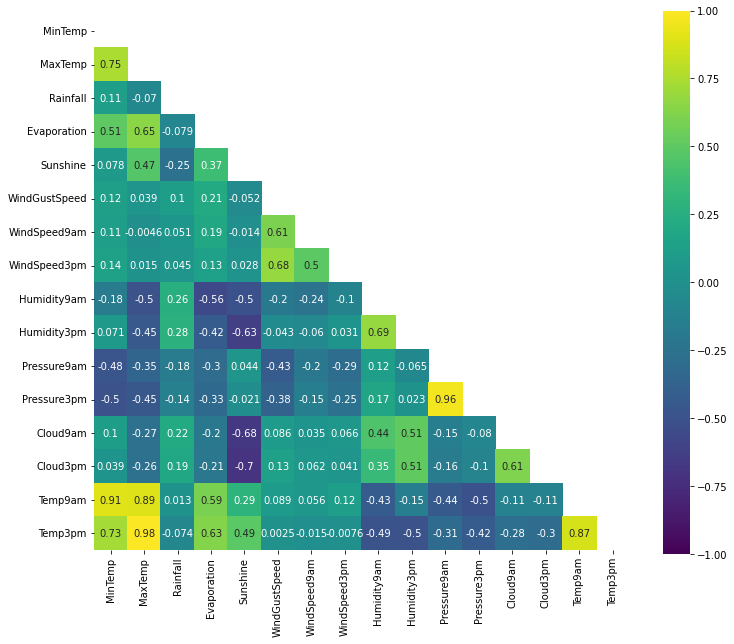

In [ ]:
corrMatrix = xtrain[num_var].corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,10))

sns.heatmap(corrMatrix, mask=mask, square=True, annot=True, vmax=1, vmin=-1, cmap='viridis')

## Standardizzazione

In [ ]:
scaler = StandardScaler()
scaler.fit(xtrain[num_var])
xtrain_num = pd.DataFrame(scaler.transform(xtrain[num_var]), columns=xtrain[num_var].columns, index = xtrain.index)

In [ ]:
#applicata al validation
xval_num = pd.DataFrame(scaler.transform(xval[num_var]), columns=xval[num_var].columns, index = xval.index)
#applicata al test
xtest_num = pd.DataFrame(scaler.transform(xtest[num_var]), columns=xtest[num_var].columns, index = xtest.index)

## One-Hot Encoding

In [ ]:
enc = OneHotEncoder()
enc.fit(xtrain[cat_var])
xtrain_cat = pd.DataFrame(enc.transform(xtrain[cat_var]).toarray(), 
                          columns=enc.get_feature_names_out(), index = xtrain.index)

In [ ]:
# Applicata al validation
xval_cat = pd.DataFrame(enc.transform(xval[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xval.index)
# Applicata al test
xtest_cat = pd.DataFrame(enc.transform(xtest[cat_var]).toarray(), columns=enc.get_feature_names_out(), index = xtest.index)

Le variabili vengono congiunte in un dato unico

In [ ]:
Xtrain = pd.merge(xtrain_num, xtrain_cat, left_index=True, right_index=True)
Xval = pd.merge(xval_num, xval_cat, left_index=True, right_index=True)
Xtest = pd.merge(xtest_num, xtest_cat, left_index=True, right_index=True)

## Oversampling

In [ ]:
# Oversampling con SMOTENC (SMOTENC a differenza di SMOTE tiene conto anche delle variabili categoriche)
smnc = SMOTENC(categorical_features=np.arange(12,88,1), sampling_strategy= 0.85, random_state=42)
xtrain_res, ytrain_res = smnc.fit_resample(Xtrain, ytrain)

In [ ]:
print(ytrain.value_counts())
print(ytrain_res.value_counts())

0    35634
1    10066
Name: RainTomorrow, dtype: int64
0    35634
1    30288
Name: RainTomorrow, dtype: int64


In [ ]:
# Proporzione
print(ytrain.value_counts()/len(ytrain))
print(ytrain_res.value_counts()/len(ytrain_res))

0    0.779737
1    0.220263
Name: RainTomorrow, dtype: float64
0    0.540548
1    0.459452
Name: RainTomorrow, dtype: float64


## Modeling

In [ ]:
Xtrain.shape

(45700, 92)

In [ ]:
initializer = tf.keras.initializers.GlorotUniform(seed=42) 
model=Sequential()
model.add(Dense(128, activation='relu', input_shape=(92,), kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.4))
model.add(Dense(16,activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = metrics)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11904     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
n_epochs = 50
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.001, verbose=1, restore_best_weights=True) 

history = model.fit(xtrain_res, ytrain_res, epochs=n_epochs, batch_size=batch_size, 
                    verbose=2, validation_data=(Xval, yval),callbacks=[early_stop])

Epoch 1/50
2061/2061 - 6s - loss: 0.5291 - accuracy: 0.7291 - recall_m: 0.6932 - precision_m: 0.7090 - f1_m: 0.6934 - val_loss: 0.4125 - val_accuracy: 0.7926 - val_recall_m: 0.7608 - val_precision_m: 0.5218 - val_f1_m: 0.6013 - 6s/epoch - 3ms/step
Epoch 2/50
2061/2061 - 4s - loss: 0.4327 - accuracy: 0.8082 - recall_m: 0.7887 - precision_m: 0.7910 - f1_m: 0.7841 - val_loss: 0.3930 - val_accuracy: 0.8129 - val_recall_m: 0.7315 - val_precision_m: 0.5624 - val_f1_m: 0.6145 - 4s/epoch - 2ms/step
Epoch 3/50
2061/2061 - 8s - loss: 0.3927 - accuracy: 0.8294 - recall_m: 0.8033 - precision_m: 0.8210 - f1_m: 0.8066 - val_loss: 0.3718 - val_accuracy: 0.8287 - val_recall_m: 0.6974 - val_precision_m: 0.5992 - val_f1_m: 0.6249 - 8s/epoch - 4ms/step
Epoch 4/50
2061/2061 - 7s - loss: 0.3674 - accuracy: 0.8431 - recall_m: 0.8151 - precision_m: 0.8393 - f1_m: 0.8218 - val_loss: 0.3602 - val_accuracy: 0.8381 - val_recall_m: 0.6770 - val_precision_m: 0.6282 - val_f1_m: 0.6312 - 7s/epoch - 4ms/step
Epoch 5/

<Figure size 1152x864 with 0 Axes>

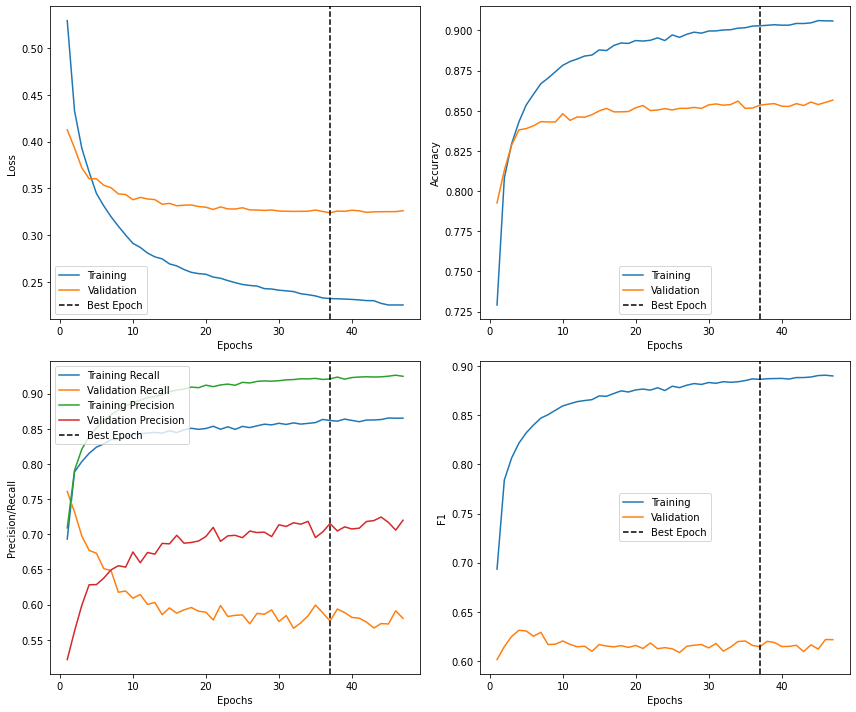

In [ ]:
try:
  x_plot = list(range(1,early_stop.best_epoch+early_stop.patience+2))
except:
  x_plot = list(range(1,n_epochs+1))
plot_history(history, x_plot)

L'andamento della Recall è anomalo, la probabile causa è da identificare nei dati creati con l'oversampling.

In [ ]:
print('Classification Report')
predictions = model.predict(Xval)
y_classes = (predictions > 0.5).astype(np.int8)
print(classification_report(yval,y_classes))
print('*****************************')
print('Confusion Matrix')
cm = confusion_matrix(yval,y_classes)
print(cm)
print('*****************************')
AUC = roc_auc_score(yval, y_classes)
print('AUC: {}'.format(AUC))

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3960
           1       0.71      0.57      0.63      1118

    accuracy                           0.85      5078
   macro avg       0.80      0.75      0.77      5078
weighted avg       0.85      0.85      0.85      5078

*****************************
Confusion Matrix
[[3697  263]
 [ 481  637]]
*****************************
AUC: 0.7516766502231619
